# Splitting Program Development

Dette notebook, forsøger at udvikle koden til at splitte det cleanede datasæt ind i et *training set*, et *validation set* og et *testing set*, som hhv. vil være givet ved 80%, 10%, 10%.

## Reading the Dataset

Da det splittede datasæt, skal kunne bruges i Part 2, hvor brug af meta-data er tilladt, og i Part 3, hvor brug af meta-data ikke er tilladt, er det nødvendigt at indlæse hele datasættet, altså alle kolonnerne.

For at indlæse datasættet, gør jeg brug af ``pandas``.

In [65]:
import pandas as pd

# Reading the cleaned dataset
dataset = pd.read_csv('../cleaned_dataset_FULL.csv', low_memory=False)
dataset

,id,domain,type,url,content,scraped_at,inserted_at,updated_at,title,authors,keywords,meta_keywords,meta_description,tags,summary,source,cleaned content
0,7444726.0,nationalreview.com,political,http://www.nationalreview.com/node/152734/%E2%...,Plus one article on Google Plus\n\n(Thanks to ...,2017-11-27T01:14:42.983556,2018-02-08 19:18:34.468038,2018-02-08 19:18:34.468066,Iran News Round Up,NaN,NaN,"['National Review', 'National Review Online', ...",NaN,NaN,NaN,NaN,"['plu', 'one', 'articl', 'googl', 'plu', 'than..."
1,6213642.0,beforeitsnews.com,fake,http://beforeitsnews.com/economy/2012/06/the-c...,The Cost Of The Best Senate Banking Committee ...,2017-11-27T01:14:08.7454,2018-02-08 19:18:34.468038,2018-02-08 19:18:34.468066,The Cost Of The Best Senate Banking Committee ...,NaN,NaN,[''],NaN,NaN,NaN,NaN,"['cost', 'best', 'senat', 'bank', 'committe', ..."
2,3867639.0,dailycurrant.com,satire,http://dailycurrant.com/2016/01/18/man-awoken-...,Man Awoken From 27-Year Coma Commits Suicide A...,2017-11-27T01:14:21.395055,2018-02-07 23:39:33.852671,2018-02-07 23:39:33.852696,Man Awoken From 27-Year Coma Commits Suicide A...,NaN,NaN,[''],NaN,NaN,NaN,NaN,"['man', 'awoken', '<NUM>', 'year', 'coma', 'co..."
3,9560791.0,nytimes.com,reliable,https://query.nytimes.com/gst/fullpage.html?re...,WHEN Julia Geist was asked to draw a picture o...,2018-02-11 00:46:42.632962,2018-02-11 00:14:20.346838,2018-02-11 00:14:20.346871,Opening a Gateway for Girls to Enter the Compu...,NaN,NaN,"['Computers and the Internet', 'Women and Girl...",WHEN Julia Geist was asked to draw a picture o...,NaN,NaN,nytimes,"['julia', 'geist', 'ask', 'draw', 'pictur', 'c..."
4,2059625.0,infiniteunknown.net,conspiracy,http://www.infiniteunknown.net/2011/09/14/100-...,– 100 Compiled Studies on Vaccine Dangers (Act...,2017-11-10T11:18:44.524042,2018-02-07 23:39:33.852671,2018-02-07 23:39:33.852696,100 Compiled Studies on Vaccine Dangers – Infi...,NaN,NaN,[''],NaN,"Lymphoma, Hepatitis B, Immune System, Health, ...",NaN,NaN,"['<NUM>', 'compil', 'studi', 'vaccin', 'danger..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
994983,1304673,21stcenturywire.com,conspiracy,http://21stcenturywire.com/tag/kony-2012/,By\n\n21WIRE + Intervention Watch | All we can...,2017-11-09T12:48:34.461199,2018-02-07 23:39:33.852671,2018-02-07 23:39:33.852696,KONY 2012 Archives,NaN,NaN,[''],NaN,"Michelle Obama, Drones, Selfie, Uganda, smart ...",NaN,NaN,"['<NUM>', 'wire', '+', 'intervent', 'watch', '..."
994984,7273484,nationalreview.com,political,http://www.nationalreview.com/node/152734/%E2%...,Plus one article on Google Plus\n\n(Thanks to ...,2017-11-27T01:14:42.983556,2018-02-08 19:18:34.468038,2018-02-08 19:18:34.468066,Iran News Round Up,NaN,NaN,"['National Review', 'National Review Online', ...",NaN,NaN,NaN,NaN,"['plu', 'one', 'articl', 'googl', 'plu', 'than..."
994985,3489380,thesaker.is,unknown,http://thesaker.is/china-and-russia-are-acquir...,"China and Russia are Acquiring Gold, Dumping U...",2017-11-18T20:01:27.400599,2018-02-07 23:39:33.852671,2018-02-07 23:39:33.852696,"China and Russia are Acquiring Gold, Dumping U...",The Saker,NaN,[''],A bird's eye view of the vineyard,"Gold, Dollar, Russia, China",NaN,NaN,"['china', 'russia', 'acquir', 'gold', 'dump', ..."
994986,6315455,express.co.uk,rumor,https://www.express.co.uk/pictures/sport/6708/...,Liverpool have signed Sadio Mane from Southamp...,2017-11-27T01:14:33.570665,2018-02-08 19:18:34.468038,2018-02-08 19:18:34.468066,Twitter reacts as Liverpool sign Sadio Mane,NaN,NaN,[''],Express Sport brings you all the best tweets a...,NaN,NaN,NaN,"['liverpool', 'sign', 'sadio', 'mane', 'southa..."


## Pre-processing

På datasættet skal der foretages yderligere processing, som ikke nødvendigvis fandt sted i pre-processing pipelinenen. Disse inkludere:
- Fjerne rækker med ``NaN`` værdier i ``type`` kolonnen.
- Fjerne rækker med ``NaN`` værdier i ``cleaned content`` kolonnen
- Fjerne dubletter i ``cleaned content`` kolonnen

In [66]:
# removing NaN values
dataset = dataset.dropna(subset=['cleaned content','type'])

# removing dublicate data
dataset = dataset.drop_duplicates(subset='cleaned content', keep='first')

Ydermere ses det, hvis man undersøger fordelingen af typerne, at der er en enkelt fejl type (``2018-02-10 13:43:39.521661``), som uden tvivl ikke høre til, som derfor også må fjernes. Se nedenfor:

In [67]:
dataset['type'].value_counts()

type
reliable                      211503
political                     135998
bias                           97522
fake                           92549
conspiracy                     69903
rumor                          52600
unknown                        32233
clickbait                      25827
unreliable                     13807
junksci                        11425
satire                         10659
hate                            8315
2018-02-10 13:43:39.521661         1
Name: count, dtype: int64

Denne fejl værdi fjernes nedenfor.

In [68]:
dataset = dataset[dataset['type'] != '2018-02-10 13:43:39.521661']

## Splitting

Til at splitte datasættet ind i de forskellige sets, bruger jeg ``train_test_split`` funktionen fra ``sklearn.model_selection``. Denne er en simpel og hurtig funktion til at opdele datasættet. I funktionen bruger jeg ``random_state=50``, til at shuffle datasættet, men da inputtet er en ``int``, betyder det at outputtet er deterministisk. Ydermere bruger jeg ``stratify=dataset['type']``, som sørger for at fordellingen af de 12 typer, forbliver ens, mellem de 2 split.

Nedenfor splitter jeg først datasættet ind i *training set* og *validation + testing set*:

In [75]:
from sklearn.model_selection import train_test_split

# Splitting the dataset into: Training and Validation+Testing
training_valitest_split = train_test_split(dataset, dataset['type'], test_size=0.2, random_state=50, stratify=dataset['type'])[:2]

Nu kan jeg så splitte *validation + testing* settet, i 50:50, hvilket betyder at de hver især vil udgøre 10% af det samlede datasæt.

In [76]:
# Splitting the dataset into: Training and Validation+Testing
validation_testing_split = train_test_split(training_valitest_split[1], training_valitest_split[1]['type'], test_size=0.5, random_state=50, stratify=training_valitest_split[1]['type'])[:2]

Nu da jeg har alle de splits, vi skal bruge, samler jeg dem i et dictionary (ikke nødvendigt).

In [77]:
splits = {
    'Training':training_valitest_split[0],
    'Validation':validation_testing_split[0],
    'Testing':validation_testing_split[1]
    }

Nedenfor kode er genereret med Copilot, og er til for at vise at, fordelingen af de forskellige typer de de forskellige split faktisk er ens.

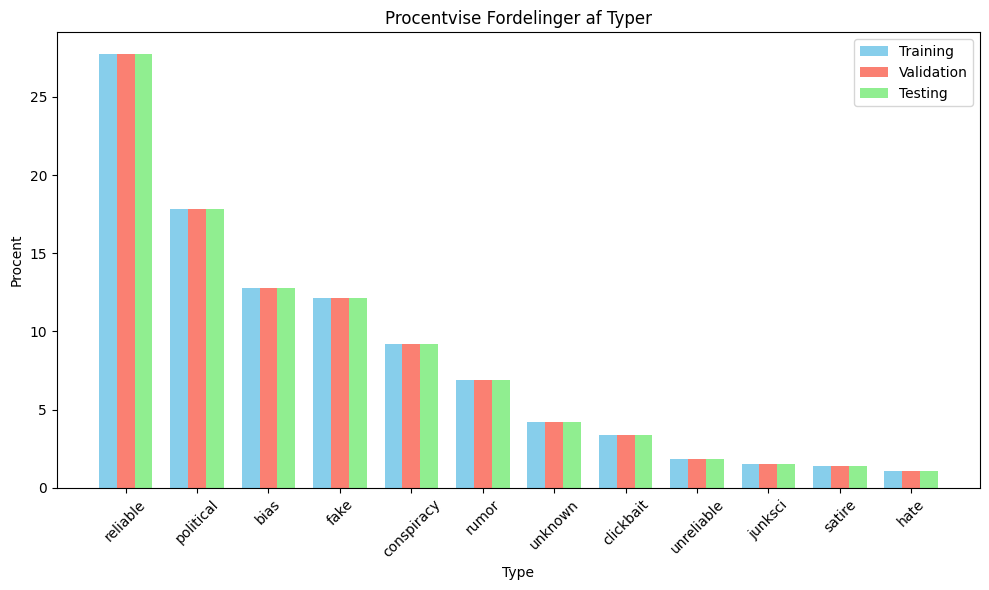

In [72]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Kombiner serierne til en DataFrame
df = pd.DataFrame({
    'Training': splits['Training']['type'].value_counts(),
    'Validation': splits['Validation']['type'].value_counts(),
    'Testing': splits['Testing']['type'].value_counts()
})

# Beregn procentfordelinger for hver serie
df_percent = df.div(df.sum(axis=0), axis=1) * 100  # Divider hver værdi med summen af sin kolonne

# Opret placeringer til søjler
x = np.arange(len(df.index))  # Antal typer (Type1, Type2 osv.)
width = 0.25  # Bredden på hver søjle

# Tegn søjler for procentfordeling
plt.figure(figsize=(10, 6))
plt.bar(x - width, df_percent['Training'], width=width, label='Training', color='skyblue')
plt.bar(x, df_percent['Validation'], width=width, label='Validation', color='salmon')
plt.bar(x + width, df_percent['Testing'], width=width, label='Testing', color='lightgreen')

# Tilføj labels, titler og aksejustering
plt.xlabel('Type')
plt.ylabel('Procent')
plt.title('Procentvise Fordelinger af Typer')
plt.xticks(x, df.index, rotation=45)  # Sæt Type1, Type2 osv. som x-aksetiketter
plt.legend()
plt.tight_layout()
plt.show()


## Grouping classes *(Optional)*

Denne del er ikke krav, men er anbefalet. Denne del vil forsøge at gruppere de 12 klasser under 2 overklasser eller grupper, hhv. ``fake`` og ``reliable``. Måden hvorpå dette gøres, tager stærk inspiration fra Exercise 2, hvor selvsamme opgave skulle udføres. Den følgende del er taget fra min egen aflevering:

Det næste jeg nu vil gøre er at bruge tabellen nedenfor, fra [GitHub]('https://github.com/several27/FakeNewsCorpus'), hvor der står en forklaring på alle de forskellige ``tag``'s, som findes i kolonnen ``type`` i datasættet, til at finde ud af hvilke artikler jeg ellers burde fjerne, baseret på hvilket tag de har fået, og hvordan jeg selv kan organisere dem i grupperne *fake* og *reliable*, ud fra definationerne i tabellen.

| Type | Tag | Description|
| ------------- |:-------------:|:-------------:|
| **Fake News** | fake | Sources that entirely fabricate information, disseminate deceptive content, or grossly distort actual news reports |
| **Satire** | satire | Sources that use humor, irony, exaggeration, ridicule, and false information to comment on current events. |
| **Extreme Bias** | bias | Sources that come from a particular point of view and may rely on propaganda, decontextualized information, and opinions distorted as facts. |
| **Conspiracy Theory** | conspiracy | Sources that are well-known promoters of kooky conspiracy theories. |
| **State News** | state | Sources in repressive states operating under government sanction. |
| **Junk Science** | junksci | Sources that promote pseudoscience, metaphysics, naturalistic fallacies, and other scientifically dubious claims. |
| **Hate News** | hate | Sources that actively promote racism, misogyny, homophobia, and other forms of discrimination. |
| **Clickbait** | clickbait | Sources that provide generally credible content, but use exaggerated, misleading, or questionable headlines, social media descriptions, and/or images. |
| **Proceed With Caution** | unreliable | Sources that may be reliable but whose contents require further verification. |
| **Political** | political | Sources that provide generally verifiable information in support of certain points of view or political orientations. |
| **Credible** | reliable | Sources that circulate news and information in a manner consistent with traditional and ethical practices in journalism (Remember: even credible sources sometimes rely on clickbait-style headlines or occasionally make mistakes. No news organization is perfect, which is why a healthy news diet consists of multiple sources of information). |


Ud fra tabellen og typerne tilstede i datasættet har jeg lavet følgende grupper:
- Fjernes:
    - unknown
    - unreliable
- Falsk:
    - fake
    - conspiracy
    - junksci
    - satire
- Utroværdig:
    - bias
    - state
    - hate
    - rumor
- Troværdig:
    - reliable
    - clickbait
    - political

Gruppen *Fjernes* består af de tags og tilhørende artikler, som skal fjernes fra datasættet, da de har lille eller ingen værdi til at træne en model, da det ikke vides hvilket kategori de høre ind under, og derfor kunne gøre mere skade end gavn.

Gruppen *Falsk* (*Fake*) er de tags, som ud fra ovenstående tabel definationer, må kunne defineres som opdigtede eller fordrejede i så høj grad at de ikke længere at tæt på en akkurat repræsentation af virkeligheden eller sandheden. Her har jeg valgt at *conspiracy* og *junksci* skal høre ind under *Falsk*, da disse omhandler emner, som er svagt eller helt mangler faktuelle belæg, og i nogle tilfælde er blevet modbevist. 

Gruppen *Troværdig* (*Reliable*) er de tags, som ovenstående tabel definere, som indeholdene faktuelt indhold, hvis sandhed kan verificeres. Jeg har valgt at *clickbait* og *political* høre ind under denne katogori, da disse selvom de kan være misvisende eller er biased i større eller mindre (men ikke ekstrem) grad, så er det stadig faktuelt indhold og verificerbart indhold.

Gruppen *Utroværdig* er de tags som ud fra ovenstående definationer, er i en sådan gråzone mellem sand og falsk, da *hate* overvejende er meningstekster, som ikke nødvendigvis indeholder løgne, da *state* som fordræjer sandheden, men i større eller mindre grad kan basere sig på sandheden, og *bias* som kan gøre brug af propaganda eller misbruge information, på en måde der fordrejer sandheden (*rumor* er tilføjet her, da denne er svært troværdig). Derfor mener jeg egentlig at de er en gruppe for sig selv, men da jeg skal klassificere alle artikler jeg beholder, som enten *Fake* eller *Reliable* mener jeg at da de i hvert fald ikke høre under *Reliable* grundet deres svage grundlag i sandheden og fordrejning af virkeligheden, må de høre under *Fake*.

Dermed fås grupperne:
- **Fake**:
    - fake
    - conspiracy
    - junksci
    - satire
    - bias
    - state
    - hate
    - rumor
- **Reliable**:
    - realiable
    - clickbait
    - political

Nedenfor udføres denne gruppering af klasser.

In [78]:
for split in splits:
    # removing unwanted data
    splits[split] = splits[split][~splits[split]['type'].isin(['unknown', 'unreliable'])]

    # creating classes
    splits[split] = splits[split].replace({'conspiracy':'fake', 'junksci':'fake', 'satire':'fake', 'bias':'fake', 'state':'fake', 'hate':'fake', 'rumor':'fake'})
    splits[split] = splits[split].replace({'clickbait':'reliable', 'political':'reliable'})

Da jeg ovenfor har vist at fordelingen af klasser var ens mellem *training set*, *validation set* og *testing set*, viser jeg nu kun fordelingen mellem *fake* og *reliable* i *trainning set*.

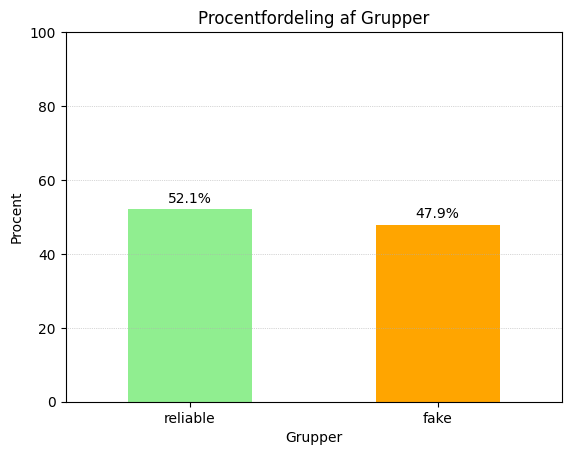

In [80]:
import matplotlib.pyplot as plot

group_procent = splits['Training']['type'].value_counts(dropna=0).apply(lambda x: 100*x/splits['Training'].__len__())
group_procent.plot(kind='bar', color=['lightgreen', 'orange'], title='Procentfordeling af Grupper', xlabel='Grupper', ylabel='Procent')
for i, v in enumerate(group_procent):
    plot.text(i, v + 1, f"{v:.1f}%", ha='center', va='bottom')
plot.grid(True, axis='y', linestyle=':', linewidth=0.5)
plot.xticks(rotation=0)
plot.ylim(0, 100)
plot.show()

Det ses her at datasættet er ikke helt balanceret, men det er ret tæt på. For sjovs skyld testede jeg, hvilken effekt det havde at rykke *clickbait* fra *reliable* til *fake*, hvilken fik *fake* klassen til at gå fra 47,9% til 48,5%, hvilket ville gøre datasættet mere balanceret, men kunne gøre mere skade end gavn, da *clickbait* teknisk set ikke er *fake news*.

## Writing the files

Da datasættet nu er færdigt splittet og fordelingen af klasser er ens mellem splitsne, kan de splittede set nu laves som til csv filer, så de kan bruges på et senere tidspunkt til at træne klassifikations modeller.

Nedenfor laves følgende filer, i hovedmappen: *Training_dataset.csv*, *Validation_dataset.csv* og *Testing_dataset.csv*

In [ ]:
for split, data in splits.items():
    data.to_csv(f'../{split}_dataset.csv', index=False)